<center>
    <b><h1> Couserwork Assignment: Text Classification</h1></b>
</center>

<center>
    <h3>University of London</h3>
</center>

<center>
    <h3>BSc in Computer Science</h3>
</center>

<center>
    <h3>Natural Language Processing</h3>
</center>

<div style="page-break-after: always;"></div>

<h1> Table of Content</h1>

<style>
ul {
    font-size: 20px;
}

ul ul {
    font-size: 15px;
}
</style>

<ul>
    <li>
        <a href="#intro">1. Introduction</a>
        <ul>
            <li><a href="#1.1">1.1 Problem Area</a></li>
            <li><a href="#1.2">1.2 Objectives</a></li>
            <li><a href="#1.3">1.3 Choice of Dataset</a></li>
        </ul>
    </li>
    <li>
        <a href="#implementation">2. Implementation</a>
        <ul>
            <li><a href="#2.1">2.1 Processing</a></li>
            <ul>
                <li><a href="#2.1.1">2.1.1 Data Extraction and Cleaning</a></li>
                <li><a href="#2.1.2">2.2.2 Prelimary Data Exploration and Data Cleaning</a></li>
                <li><a href="#2.1.3">2.3.3 Vocabulary statistic</a></li>
            </ul>
            <li><a href="#2.2">2.2 Baseline performance</a></li>
        </ul>
    </li>
    <li>
        <a href="#Conc">3. Conclusion</a>
        <ul>
            <li><a href="#3.1">3.1 Evaluation</a></li>
            <li><a href="#3.2">3.2 Project Evaluation and Summary</a></li>
        </ul>
    </li>
</ul>


<div style="page-break-after: always;"></div>

<h2 id="intro">1. Introduction</h2>
<h3 id="1.1">1.1 Problem area</h3>

<h3 id="1.2">1.2 Objectove</h3>

<h3 id="1.3">1.3 Choice of Dataset</h3>

<h3 id="1.4">1.4 Evaluation Methodology</h3>

<h2 id="implementation">2. Implementation</h2>
<h3 id="2.1">2.1 Processing</h3>
<h3 id="2.1.1">2.1.1 Data extraction</h3>

Data will be extracted and stored locally. To extract the data required for the Natural Language Processing, some libraries were imported.

In [1]:
# Import library needed for data analysis

# os is used for handling the system
import os

# random for randomly selecting the data
import random

# pandas for storing and handling the data in data frame
import pandas as pd

# matplotlib for visualising the data
import matplotlib.pyplot as plt

# Regular expression handling
import re

# Numpy for calculation
import numpy as np

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords #stop words removal
from nltk.stem import WordNetLemmatizer #replace words with similar meaning
from nltk.tokenize import word_tokenize #tokenizing the string
from nltk import ne_chunk
from nltk.tree import Tree
from nltk.collocations import BigramCollocationFinder #collation calculation
from nltk.metrics import BigramAssocMeasures #collation calculation
from nltk.probability import FreqDist #distribution calculation

# RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Navie Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# BoW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# comparison
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Bert
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error

# wordcould display
from wordcloud import WordCloud

# spliting of data into test and train dataset
from sklearn.model_selection import train_test_split

The location of the data file is specified to extract the data

In [2]:
# Path to the folders
pos_folder = r'C:\Users\xjie\Documents\SIM\Y3S2\nlp\aclImdb\train\pos'
neg_folder = r'C:\Users\xjie\Documents\SIM\Y3S2\nlp\aclImdb\train\neg'

<b>Format of data:</b> As the data obtained is in the form of text document stored in positive and negative sentiment folder with each individual file name as the rating and the ID, a file counter is needed to check for the length of the data

In [3]:
# Helper functions;

# Count the number of files in the data folder
def count_files(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return

    file_count = 0

    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

Using the function as define above, the number of the files in both positive and negative folder are obtained: 

In [4]:
# Positive data file avaliable
file_count = count_files(pos_folder)
print(f"The number of files in positive data folder is: {file_count}")

The number of files in positive data folder is: 12500


In [5]:
# Negative data file avaliable 
file_count = count_files(neg_folder)
print(f"The number of files in nagtive data folder is: {file_count}")

The number of files in nagtive data folder is: 12500


As this training data set is <b>too big</b> for the computer, only <b>5000 data</b> from positive and negative folder respectively will be selected to make the program runs faster. Then these data will be further seperated into test and training sets.

Some helper functions are defined to extract the information and data from the data folder:

In [6]:
# Helper functions

# Function to extract unique ID and rating from file name
def extract_info(file_name):
    id_rating = file_name.split('.')[0]
    unique_id, rating = id_rating.split('_')
    return int(unique_id), int(rating)

# Function to extract the data from the file based on the aclImdb data structure
def extract_files(folder, num_files, sentiment):
    files = random.sample(os.listdir(folder), num_files)
    data = pd.DataFrame(columns=['Sentiment', 'Unique ID', 'Rating', 'Content'])
    
    for file_name in files:
        file_path = os.path.join(folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read() # read content for the review
        unique_id, rating = extract_info(file_name)  # get ID and rating from file name
        file_data = pd.DataFrame({'Sentiment': [sentiment], 'Unique ID': [unique_id], 'Rating': [rating], 'Content': [content]})
        data = pd.concat([data, file_data], ignore_index=True)
    
    return data

In [7]:
# Extracting data
pos_data = extract_files(pos_folder, 5000, 'pos')
neg_data = extract_files(neg_folder, 5000, 'neg')

# Print the resulting DataFrame
raw_data = pd.concat([pos_data, neg_data], ignore_index=True)

# Display the start of the data
raw_data.head()

,Sentiment,Unique ID,Rating,Content
0,pos,2501,8,I'm a fan of both actors/singers especially Ga...
1,pos,5026,8,This is a great movie that everyone should see...
2,pos,5107,10,What an overlooked 80's soundtrack. I imagine ...
3,pos,12180,10,"In my opinion, A GUY THING is a hilarious, wit..."
4,pos,6745,8,A Turkish Bath sequence in a film noir loc...


<br>

<h3 id="2.1.2">2.1.2 Prelimary Data Exploration and Data Cleaning</h3>

In [8]:
# Examining the data
raw_data.describe()

,Sentiment,Unique ID,Rating,Content
count,10000,10000,10000,10000
unique,2,8039,8,9976
top,pos,5324,1,This show comes up with interesting locations ...
freq,5000,2,2025,3


It was noted that both Unique ID and Content has duplicated values after the extraction as the frequency of the data is not 1. 

However, it is <b>not ideal</b> for the model to take in repeated reading in the content field as it does not add any more knowlegde to the model. Moreover, the original unique ID also do not provide much information after combining the data from both positive sentiment and negative sentiment.

Thus, an algorithm will be implemented to check for these values and handle them.

<b>For duplicates in Unique ID</b>, as a <b>new ID will be assigned</b> as the index for the data frame, there is <b>no need</b> for the Unique ID from positive sentiment and negative sentiment folder. Thus, the <b>unique ID column will be dropped</b>. 

<b>For duplicates in content</b>, it will first find the duplicates, then remove the <b>first instance</b> of the duplicates. To ensure the overall dataset remain balanced, it will perform the random selection of data from the original data file again. These two functions will be <b>called recursively</b> until there is <b>no repetition</b> in the dataframe. The cleaned data will be saved in a new data frame.

<h4>Removing duplicates and old Unique ID</h4>

In [9]:
# Remove unique ID column from the data
org_ID_removed_data = raw_data.drop("Unique ID", axis=1)

In [10]:
# Helper function

# Check for repetetion of data
def find_duplicates(dataframe, column):
    duplicates = dataframe[dataframe[column].duplicated(keep=False)]
    duplicates_sorted = duplicates.sort_values(by=column)

    if duplicates_sorted.empty:
        print("No repeated data entry found.")
    else:
        print("Repeated data entry/entries found in "+str(column))
        duplicates_pairs = duplicates_sorted.groupby(column).apply(lambda x: x.reset_index(drop=True))
        duplicates_pairs.reset_index(drop=True, inplace=True)
        return duplicates_pairs
    
# replace duplicates with other values
def get_balance_data_with_duplicates(duplicate_content, original_data, pos_folder, neg_folder):
    # Remove the first occurrence of unique items in the duplicated content
    data_to_remove = duplicate_content.drop_duplicates(subset='Content', keep='first')
    org_ID_removed_data = original_data.drop_duplicates(subset='Content', keep='first')

    # Count the number of pos and neg entries in 'data_to_remove'
    pos_count = data_to_remove[data_to_remove['Sentiment'] == 'pos'].shape[0]
    neg_count = data_to_remove[data_to_remove['Sentiment'] == 'neg'].shape[0]

    # Add the removed duplicates such that the data is balanced
    added_pos_data = extract_files(pos_folder, pos_count, 'pos')
    added_neg_data = extract_files(neg_folder, neg_count, 'neg')

    # Remove the 'Unique ID' column from added data
    added_pos_data.drop("Unique ID", axis=1, inplace=True)
    added_neg_data.drop("Unique ID", axis=1, inplace=True)

    added_data = pd.concat([added_pos_data, added_neg_data], ignore_index=True)
    balanced_data = pd.concat([org_ID_removed_data, added_data], ignore_index=True)

    return balanced_data

# recursively call the previouse two function untill data is balanced and no repetition
def recursive_data_balancing(dataframe, column, pos_folder, neg_folder):
    duplicates = find_duplicates(dataframe, column)

    if duplicates is None:
        print("No more duplicates found.")
        return dataframe

    # Call get_balance_data_with_duplicates with the duplicate content
    balanced_data = get_balance_data_with_duplicates(duplicates, dataframe, pos_folder, neg_folder)

    # Recursively check for duplicates
    print("Recursive call to balance the data.")
    return recursive_data_balancing(balanced_data, column, pos_folder, neg_folder)

In [11]:
balanced_data = recursive_data_balancing(org_ID_removed_data, 'Content', pos_folder, neg_folder)

Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
Repeated data entry/entries found in Content
Recursive call to balance the data.
No repeated data entry found.
No more duplicates found.


<h4>Simple statistic analysis</h4>

Besides the ensure balancing and no repetition of data, some other checks were also performed on the dataset

In [12]:
# checking the overall information
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  9999 non-null   object
 1   Rating     9999 non-null   object
 2   Content    9999 non-null   object
dtypes: object(3)
memory usage: 234.5+ KB


In [13]:
# check for null data
balanced_data.isnull().sum()

Sentiment    0
Rating       0
Content      0
dtype: int64

In [14]:
# double checking for unique data
balanced_data.nunique()

Sentiment       2
Rating          8
Content      9999
dtype: int64

In [15]:
# double checking the total number of data entries
print("Number of entries in 'Sentiment' column:", balanced_data['Sentiment'].shape[0])
print("Number of entries in 'Rating' column:", balanced_data['Rating'].shape[0])
print("Number of entries in 'Content' column:", balanced_data['Content'].shape[0])

Number of entries in 'Sentiment' column: 9999
Number of entries in 'Rating' column: 9999
Number of entries in 'Content' column: 9999


In [16]:
balanced_data['Sentiment'].value_counts()

Sentiment
pos    5000
neg    4999
Name: count, dtype: int64

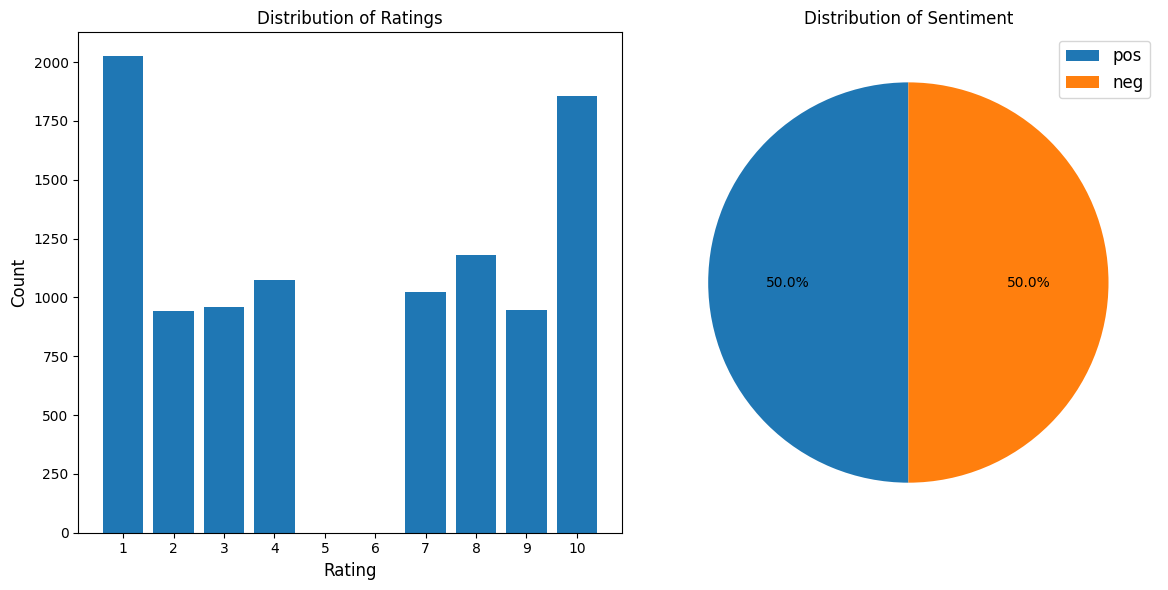

In [17]:
# Plot a grpah to show the distribition of ratings
import matplotlib.pyplot as plt

# Distribution of Ratings
rating_counts = balanced_data['Rating'].value_counts().sort_index()

# Distribution of Sentiment
sentiment_counts = balanced_data['Sentiment'].value_counts()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Distribution of Ratings
ax1.set_xticks(range(1, 11))
ax1.set_xticklabels(range(1, 11))
ax1.bar(rating_counts.index, rating_counts.values)
ax1.set_xlabel('Rating', fontsize=12)
ax1.set_ylabel('Count',  fontsize=12)
ax1.set_title('Distribution of Ratings')

# Plot Distribution of Sentiment
ax2.pie(sentiment_counts.values, 
        labels=None, 
        autopct='%1.1f%%', 
        startangle=90) # no labels, set as 1 decimal place, title the angle by 90 degree
ax2.set_title('Distribution of Sentiment')
ax2.legend(sentiment_counts.index, loc="best", fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

It can be seen that this dataframe contains 10000 with a <b>balanced distribution</b> of positive and negative sentiment data. The <b>most common rating</b> is 1 followed by 10. Both of them are the most frequent term in their sentiment respectively.

There is also <b>no null data</b> in all three columns.

<b>Collation</b> is obtained using BigramAssocMeasures from nltk to examine the relationship between nearby texts. This is useful to identify negations.

In [18]:
# Function to calculate collocations in a given text
def calculate_collocations(text):
    words = nltk.word_tokenize(text)
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(2)  # Adjust the frequency threshold as needed
    collocations = finder.nbest(BigramAssocMeasures.pmi, 10)  
    return collocations

# Combine the content of balanced_data['Content'] into a single string
text = ' '.join(balanced_data['Content'])

# Calculate collocations for the combined text
collocations = calculate_collocations(text)

# Create a DataFrame to store the collocations and frequencies
collocations_df = pd.DataFrame(collocations, columns=['Word 1', 'Word 2'])
collocations_df['Frequency'] = collocations_df.apply(lambda row: text.count(' '.join(row)), axis=1)

# Sort the DataFrame by frequency in descending order
collocations_df = collocations_df.sort_values('Frequency', ascending=False).reset_index(drop=True)

In [19]:
# Display the top 5 collocations with frequencies
collocations_df.head(10)

,Word 1,Word 2,Frequency
0,-Celluloid,Rehab,2
1,ALAIN,DELON,2
2,ANDREI,RUBLEV,2
3,Alok,Nath,2
4,Amores,Perros,2
5,Antonella,Ríos,2
6,Anupam,Kher,2
7,Arne,Glimcher,2
8,BRIEF,ENCOUNTER,2
9,BRITTANY,SNOW,2


Based on the analysis above, there doesnot seem to be any negations 

Next, the entries were tokenized to examine the common words used in the reviews using frequency distribution:

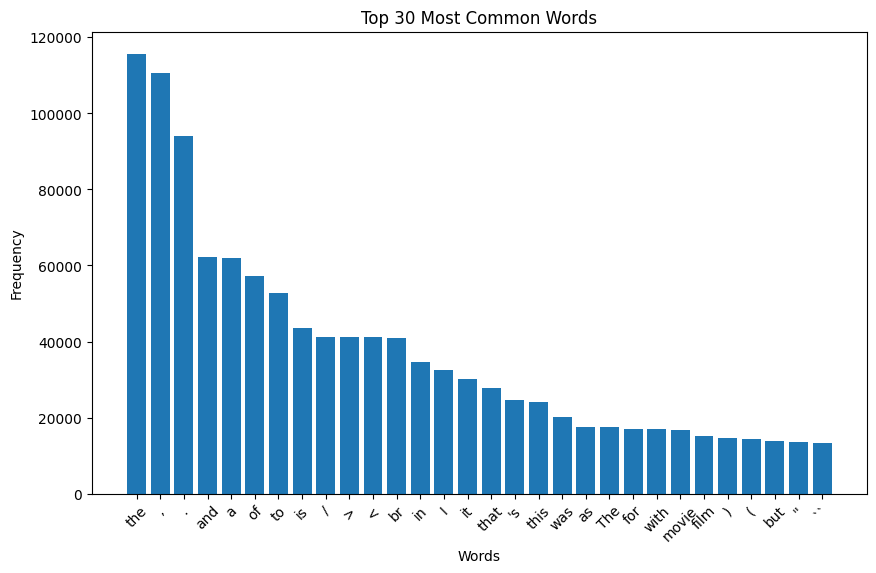

In [20]:
# Tokenize the words in the balanced_data["Content"] column
all_words = nltk.word_tokenize(' '.join(balanced_data["Content"]))

# Calculate the frequency distribution of words
freq_dist = FreqDist(all_words)

# Get the 30 most common words
most_common_words = freq_dist.most_common(30)

# Extract the words and their frequencies
words, frequencies = zip(*most_common_words)

# Plot the number of occurrences
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Common Words')
plt.xticks(rotation=45)
plt.show()

It was noted that most of the common words were <b>punctuation marks</b> (such as ",", ".", "<" and ">"), <b>determiners</b> (such as "the", "that", and "this") as well as <b>conjunctions</b> (such as "and", "for"). Thus a stopwords and punctuation removal is needed to obtain the part of the string that contains the most information. This will be done using the stopwords and Punkt tokenizer, which is a pre-trained sentence tokenizer available in NLTK.

Other common words that are present in the reviews are <b>related to the subject domain</b> (moview review. Some of the examples of these words are "movie" and "film".

It is also noted that besides the common stopwords and words that is related to the subject domain(moview review), there is also another commonly used term <b>"br"</b> further analysis of this term will thus be carried out.

<h4>Cleaning for the use of tags</h4>

In [21]:
# Filter the entries containing "br"
filtered_data = balanced_data[balanced_data["Content"].str.contains("br")]

# Create a copy of the filtered DataFrame
filtered_data = filtered_data.copy()

# Extract the substring with 10 characters before and after "br"
filtered_data.loc[:, "Snippet"] = filtered_data["Content"].str.extract(r"(.{0,10}br.{0,10})")

# Display the filtered data
filtered_data[["Snippet"]]

,Snippet
0,omment...<br /><br />I
1,ntz book.<br /><br />B
4,is movie <br /><br />t
6,"episode,<br /><br />T"
7,r anyway.<br /><br />T
...,...
9994,solve the brutal slayi
9995,isn't it.<br /><br />I
9996,when you brush your t
9997,excited.<br /><br />T


It is noticed that the dataset uses &lt;br /&gt; tag as a part of the content. This sytex is mostly used to symbolise a change of line. Thus, the &lt;br /&gt; will be removed as part of the stopwords removal. 

To prevent other issues related to tags, a further check is conducted to verify other usage of < /> and <>

In [22]:
# Filter the entries containing "<" and "/>"
data_tags = balanced_data[balanced_data["Content"].str.contains("<.*?/>")]

# Create a copy of the tags
data_tags = data_tags.copy()

# Extracting the substrings starts with "<" and end with "/>"
data_tags["tags"] = data_tags["Content"].str.extract(r"(<.*?/>)")

# Get the unique entries of tags
tags = data_tags["tags"].unique()

# Print the unique entries
for tag in tags:
    print(tag)

<br />
<3 <br />
< than 30 minutes of watching, being bored and irritated. <br />


The above algorithm confirms that the <b>only tag used</b> is &lt;br /&gt;

Thus, the data need to take not of the use of  &lt;br /&gt; when carry out stopwords removal

In [23]:
# Get the occurrences of some punctuation marks
punctuation_occurrences = {
    "/": freq_dist["/"],
    "<": freq_dist["<"],
    ">": freq_dist[">"]
}

# Display the occurrences of punctuation marks
print("Occurrences of specific punctuation marks:")
for punctuation, count in punctuation_occurrences.items():
    print(f"{punctuation}: {count}")

Occurrences of specific punctuation marks:
/: 41095
<: 41076
>: 41095


From the algorithm above, it was noticed that the use of < and > were largely the same while the use of / is slightly higher.

This could indicate <b>other usage</b> of "/" besides tags.

In [24]:
content_column = balanced_data['Content']

# Define the categories
categories = {
    'num/num': r'(?P<before>\d+(\.\d+)?)/(?P<after>\d+(\.\d+)?)',
    'num/special': r'(?P<before>\d+(\.\d+)?)/(?P<after>[\W\t])',
    'special/num': r'(?P<before>[\W\t])/(?P<after>\d+(\.\d+)?)',
    'num/alpha': r'(?P<before>\d+(\.\d+)?)/(?P<after>[a-zA-Z])',
    'alpha/num': r'(?P<before>[a-zA-Z])/(?P<after>\d+(\.\d+)?)',
    'alpha/special': r'(?P<before>[a-zA-Z])/(?P<after>[^\w\s\t])',
    'special/alpha': r'(?P<before>[^\w\s\t])/(?P<after>[a-zA-Z\s])',
    'alpha/alpha': r'(?P<before>[a-zA-Z])/(?P<after>[a-zA-Z])',
    'special/special': r'(?P<before>[^\w\s\t])/(?P<after>[^\w\s\t])',
    'space/alpha': r'(?P<before>\s)/(?P<after>[a-zA-Z])',
    'alpha/space': r'(?P<before>[a-zA-Z])/(?P<after>\s)',
    'space/space': r'(?P<before>[\s\t])/(?P<after>[\s\t])'
}

# Categorize the strings and extract characters before and after "/"
results = []
for category, pattern in categories.items():
    matches = content_column.str.extractall(pattern)
    if not matches.empty:
        matches = matches.reset_index()
        matches = matches.rename(columns={'level_0': 'index'})
        matches = matches[['index', 'before', 'after']]
        matches['category'] = category
        results.append(matches)

# Combine the results into a single dataframe
if results:
    combined_results = pd.concat(results)
    combined_results = combined_results.reset_index(drop=True)  # Reset the index
else:
    combined_results = pd.DataFrame()


The frequency of the isage can be determined using the code below:

In [25]:
category_counts = combined_results['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('count', ascending=False)
print(category_counts)

           category  count
0       alpha/alpha   1468
1           num/num    928
2       space/space     97
3       alpha/space     52
4     special/alpha     40
5   special/special     34
6         alpha/num     14
7     alpha/special      9
8       special/num      7
9         num/alpha      7
10      space/alpha      6
11      num/special      5


With that in mind, the original data was re-examined and realised the most common usage of"/" is for choices between two words, while the second most common usage is for rating (ie. 8.5/10). 

Thus, when carrying out text processing pipelines later, <b>&lt;br /&gt; will be removed </b>as it is tag that provides little insights about the text. Moreover, numbers around "/" in the form of <b>number / number</b> will also be <b>removed</b>. 

In [26]:
num_num_df = combined_results[combined_results['category'] == 'num/num'].copy()
num_num_df['string_removal'] = num_num_df['before'] + '/' + num_num_df['after']
num_num_df

,index,before,after,category,string_removal
0,0,8,10,num/num,8/10
1,6,7,10,num/num,7/10
2,16,10,10,num/num,10/10
3,23,11,10,num/num,11/10
4,26,8,10,num/num,8/10
...,...,...,...,...,...
923,9940,3,10,num/num,3/10
924,9940,1,5,num/num,1/5
925,9964,3,10,num/num,3/10
926,9988,1,2,num/num,1/2


<h4>Tokenization and lemmatization</h4>

In [27]:
# Download NLTK resources
nltk.download('stopwords', quiet=True) # Stop words removal
nltk.download('wordnet', quiet=True) # Lemmatization
nltk.download('words', quiet=True) # Spelling check
nltk.download('maxent_ne_chunker', quiet=True) # Expand short forms

True

In [28]:
def expand_short_forms(word, previous_word):
    if word == "'s":
        # Check if the previous word is a proper noun or named entity
        if previous_word[0].isupper() or isinstance(ne_chunk([(previous_word, '')]), Tree):
            # Likely indicating possession
            return word
        else:
            # Likely contraction of "is"
            return "is"
    elif word == "n't":
        return "not"
    else:
        return word

In [29]:
# Function to preprocess the text
def text_processing_pipeline(text, string=None, column=None):
    # Replace string entries
    if string is not None:
        text = text.replace(string, '')

    # Remove elements in specified column
    if column is not None:
        for element in column:
            text = text.replace(element, '')
    
    # Change all text to lower case
    text = text.lower()
    
    # Convert short forms to full format
    words = text.split()
    expanded_words = [expand_short_forms(word, words[i-1]) if i > 0 else word for i, word in enumerate(words)]
    text = ' '.join(expanded_words)

    # Remove the spacial character from the text
    text = re.sub(r'[^a-z0-9]', ' ', text)

    # Tokenization
    words = word_tokenize(text)
    
#     # Spell checking, remove if spell
#     valid_words = set(words.words())
#     words = [word for word in words if word in valid_words]

    # Stop Words removal, result stored in words
    stop_words = set(stopwords.words('english'))
    words = (word for word in words if word not in stop_words)
    
    # change to synonyms and reduce word form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Combine the words back
    text = ' '.join(word for word in words)

    # Removing spaces before and after the text
    text = text.strip()

    # Change the spaces with length more than 1 to 1
    text = re.sub(r'\s+', ' ', text)

    return text

In [30]:
# make a copy of the balanced data
processed_data = balanced_data.copy()

# Iteratively run the processing pipeline on every entry of content
for i in range(len(balanced_data)):
    processed_data.loc[i, 'Content'] = text_processing_pipeline(processed_data.loc[i, 'Content'], "<br />", num_num_df['string_removal'])
processed_data

,Sentiment,Rating,Content
0,pos,8,fan actor singer especially gackt first discov...
1,pos,8,great movie everyone see play like dean koontz...
2,pos,10,overlooked 80 soundtrack imagine john travolta...
3,pos,10,opinion guy thing hilarious witty sexy romanti...
4,pos,8,turkish bath sequence film noir located new yo...
...,...,...,...
9994,neg,4,alicia silverstone pre clueless play modern da...
9995,neg,1,wish could give movie zero even lower sadly de...
9996,pos,8,put carla shoe overworked unappreciated admini...
9997,pos,10,star trek fan long remember announced planning...


the following algorithm is used to check if the text has all being processed.

In [31]:
# Check the success of text processing
success_count = 0
for original_text, processed_text in zip(balanced_data['Content'], processed_data['Content']):

    if original_text == processed_text:
        print("Text processing failed")
    else:
        success_count +=1
if success_count == len(processed_data['Content']):
    print("Text processing success")

Text processing success


<h3 id="2.1.3">2.3 Vocabulary statistic</h3>

<h4>lexical analysis:</h4>

Lexical Diversity is calculated using the equation below. It measure of how diverse the vocabulary used in the positive and negative reviews by examining the ratio of unique words to the total number of words in the text.

$$
\text{Lexical Diversity} = \frac{\text{Number of Unique Words}}{\text{Total Number of Words}}
$$


In [32]:
# Separate the data based on sentiment
positive_data = processed_data[processed_data['Sentiment'] == 'pos']
negative_data = processed_data[processed_data['Sentiment'] == 'neg']

In [33]:
# Helper function to calculate the lexical diversity
def calculate_lexical_diversity(text):
    all_words = nltk.word_tokenize(text)
    total_words = len(all_words)
    unique_words = len(set(all_words))
    lexical_diversity = unique_words / total_words
    return lexical_diversity

In [34]:
pos_lexical_diversity = calculate_lexical_diversity(' '.join(positive_data["Content"]))
neg_lexical_diversity = calculate_lexical_diversity(' '.join(negative_data["Content"]))

print("Lexical Diversity (Positive Sentiment):", pos_lexical_diversity)
print("Lexical Diversity (Negative Sentiment):", neg_lexical_diversity)

Lexical Diversity (Positive Sentiment): 0.05554318517591492
Lexical Diversity (Negative Sentiment): 0.05585468885814881


Based on the analysis above, both datasets has similar lexical diversity.

<h4>frequency distribution</h4>

Checking the most common words and frequency distribution after tokenizing, lemmatizing and stopwords removal:

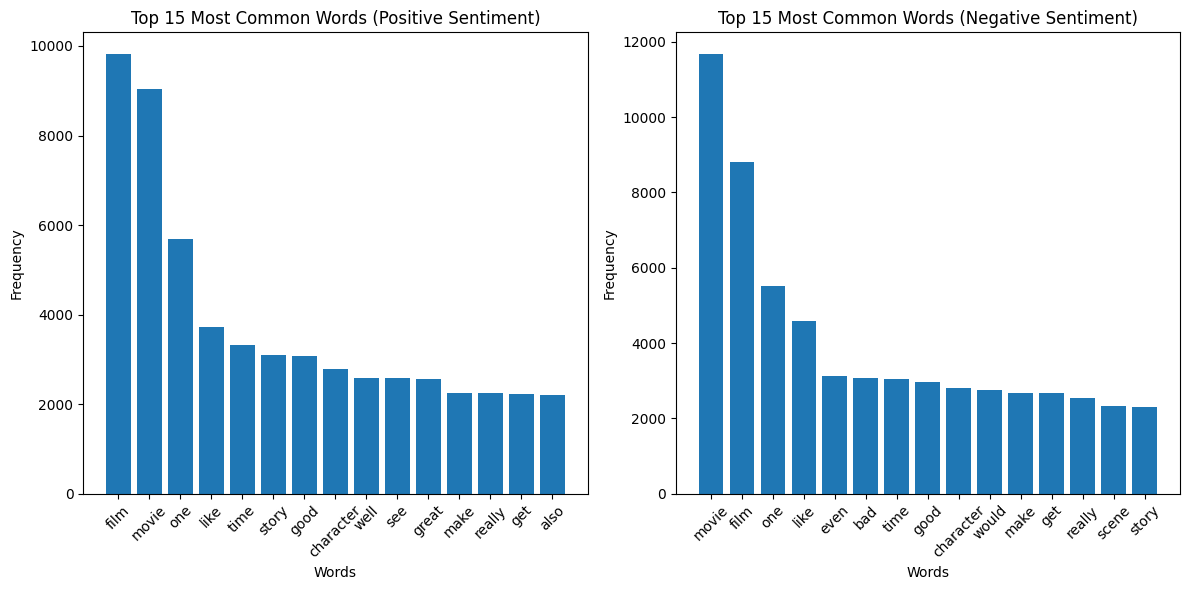

In [35]:
# Tokenize the words in the positive_data["Content"] column
positive_words = nltk.word_tokenize(' '.join(positive_data["Content"]))
positive_freq_dist = FreqDist(positive_words)
positive_common_words = positive_freq_dist.most_common(15)
positive_words, positive_frequencies = zip(*positive_common_words)

# Tokenize the words in the negative_data["Content"] column
negative_words = nltk.word_tokenize(' '.join(negative_data["Content"]))
negative_freq_dist = FreqDist(negative_words)
negative_common_words = negative_freq_dist.most_common(15)
negative_words, negative_frequencies = zip(*negative_common_words)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for positive sentiments
ax1.bar(positive_words, positive_frequencies)
ax1.set_xlabel('Words')
ax1.set_ylabel('Frequency')
ax1.set_title('Top 15 Most Common Words (Positive Sentiment)')
ax1.tick_params(axis='x', rotation=45)

# Plot for negative sentiments
ax2.bar(negative_words, negative_frequencies)
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.set_title('Top 15 Most Common Words (Negative Sentiment)')
ax2.tick_params(axis='x', rotation=45)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

From above, the most common occurance of words are film and movie. <b>Most</b> of the common words in both sentiment review dataset have a <b>neutral connotation</b>. For the top 15 most commonly used words, <b>two words</b> (good, great) in the positive sentiment data set have a <b>positive connotation</b> while there is only <b>one word</b> in the negative sentiment data set has a <b>negative connotation</b>. It is interesting to see that one word (good) with string positive connotation are present in the negative sentiment dataset. Assuming the dataset is labbeled correctly, this could be due to the <b>problem of negation</b>

A word cloud is generated to show the distribution of the words

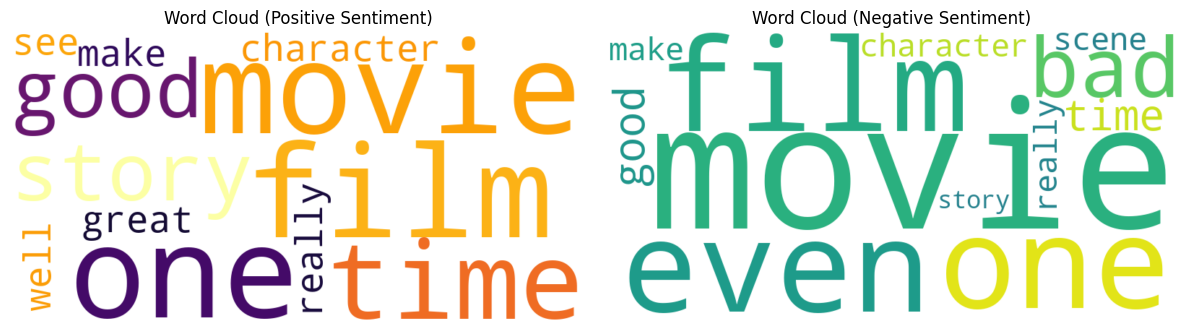

In [36]:
# Generate word cloud for positive sentiments
positive_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(' '.join(positive_words))

# Generate word cloud for negative sentiments
negative_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(' '.join(negative_words))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for positive sentiments
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Word Cloud (Positive Sentiment)')
ax1.axis('off')

# Plot for negative sentiments
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Word Cloud (Negative Sentiment)')
ax2.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

<h3 id="2.2">2.2 Baseline Performance</h3>

Evaluation matrix:

In [11]:
from sklearn.metrics import mean_squared_error

def evaluation(y_true, y_pred):
    # Calculate accuracy
    accuracy = (y_true == y_pred).mean()

    # Construct confusion matrix
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate mean squared error
    mse = mean_squared_error(y_true, y_pred)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("=" * 50)
    print("Confusion Matrix:\n", confusion_matrix)
    print("=" * 50)
    print("Precision:", precision)
    print("=" * 50)
    print("Recall:", recall)
    print("=" * 50)
    print("F1 Score:", f1)
    print("=" * 50)
    print("Mean Squared Error:", mse)

    return accuracy, confusion_matrix, precision, recall, f1, mse


In [38]:
# Predicting sentiment base on the content, thus X (features) is the content and y (target variable) is the sentiment
X = processed_data['Content']
y = processed_data['Sentiment']

In [39]:
# Split data into training and testing data with a test size of 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Save in testing and training data in a new dataframe
train_data = pd.DataFrame({'Content': X_train, 'Sentiment': y_train})
test_data = pd.DataFrame({'Content': X_test, 'Sentiment': y_test})

To achieve consistency, data is saved in the csv file

In [41]:
# Save data in csv file
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [4]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

Training and running the model RNN

In [ ]:
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Pad sequences to have consistent length
max_sequence_length = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_val_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')

# Convert sentiment labels to numeric
sentiment_mapping = {'pos': 1, 'neg': 0}
y_train_numeric = np.array([sentiment_mapping[sent] for sent in y_train])
y_val_numeric = np.array([sentiment_mapping[sent] for sent in y_val])

# Build the RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 200, input_length=max_sequence_length))
model.add(LSTM(256))
model.add(Dropout(0.2)) # add drop out
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_numeric, validation_data=(X_val_padded, y_val_numeric), epochs=5, batch_size=64)

In [ ]:
# Load the test data
test_data = pd.read_csv('test_data.csv')

# Extract the content and sentiment columns
content_test = test_data['Content'].tolist()
sentiment_test = test_data['Sentiment'].tolist()

# Tokenize the test data
test_sequences = tokenizer.texts_to_sequences(content_test)

# Pad sequences
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Convert sentiment labels to numeric
y_test_numeric = np.array([sentiment_mapping[sent] for sent in sentiment_test])

# Evaluate the model on the test data
y_pred_prob = model.predict(test_sequences_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred = y_pred.flatten()  # Flatten the predictions to match the shape of y_test_numeric

# Call the evaluation function
accuracy_RNN, confusion_matrix_RNN, precision_RNN, recall_RNN, f1_RNN, mse_RNN=evaluation(y_test_numeric, y_pred)

Naive Bayes classifier

In [44]:
# Following code is self written 
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [45]:
# Convert sentiment labels to numeric
y_val_numeric = np.array([sentiment_mapping[sent] for sent in y_val])
val_predictions_numeric = np.array([sentiment_mapping[sent] for sent in val_predictions])

# Calculate the accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_NB, confusion_matrix_NB, precision_NB, recall_NB, f1_NB, mse_NB = evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.845625
Confusion Matrix:
 Predicted    0    1
Actual             
0          693  115
1          132  660
Precision: 0.8458064516129031
Recall: 0.845503300330033
F1 Score: 0.8455593023751119
Mean Squared Error: 0.154375


SVM

In [ ]:
# Load the training data
train_data = pd.read_csv('train_data.csv')

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Train an SVM classifier
model = SVC()
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [47]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_SVM, confusion_matrix_SVM, precision_SVM, recall_SVM, f1_SVM, mse_SVM=evaluation(y_val_numeric, val_predictions_numeric)

print("Validation Accuracy:" )

Accuracy: 0.87375
Confusion Matrix:
 Predicted    0    1
Actual             
0          684  124
1           78  714
Precision: 0.8748332174468645
Recall: 0.874024902490249
F1 Score: 0.8737055996248679
Mean Squared Error: 0.12625
Validation Accuracy:


Logistic Regression (Bag of word)

In [6]:
from sklearn.preprocessing import StandardScaler

In [9]:
# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Scale the vectorized data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_vectorized)
X_val_scaled = scaler.transform(X_val_vectorized)

# Train a Logistic Regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [12]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_BoW, confusion_matrix_BoW, precision_BoW, recall_BoW, f1_BoW, mse_BoW=evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.8625
Confusion Matrix:
 Predicted    0    1
Actual             
0          689  119
1          101  691
Precision: 0.8626191592436319
Recall: 0.8625987598759877
F1 Score: 0.8624997851559143
Mean Squared Error: 0.1375


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Extract the content and sentiment columns
content = train_data['Content'].tolist()
sentiment = train_data['Sentiment'].tolist()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(content, sentiment, test_size=0.2, random_state=42)

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the content data
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

# Apply cross-validation to find the best regularization parameter
model = LogisticRegressionCV(penalty='l2', solver='lbfgs', cv=5, max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val_vectorized)

In [14]:
# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)
val_predictions_numeric = label_encoder.transform(val_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_val_numeric, val_predictions_numeric)

# Print the evaluation metrics
accuracy_LR, confusion_matrix_LR, precision_LR, recall_LR, f1_LR, mse_LR=evaluation(y_val_numeric, val_predictions_numeric)

Accuracy: 0.866875
Confusion Matrix:
 Predicted    0    1
Actual             
0          698  110
1          103  689
Precision: 0.8668693232333176
Recall: 0.8669054405440544
F1 Score: 0.8668707877085173
Mean Squared Error: 0.133125


BERT

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('textattack/bert-base-uncased-imdb')
model = AutoModelForSequenceClassification.from_pretrained('textattack/bert-base-uncased-imdb')

In [17]:
test_data = pd.read_csv('test_data.csv')
content_test = test_data['Content'].tolist()
sentiment_test = test_data['Sentiment'].tolist()

In [18]:
# Initialize empty lists for predictions and evaluation metrics
predictions = []
y_true = []

In [ ]:
# Iterate over the test data
for content, sentiment in zip(content_test, sentiment_test):
    # Encode the content using the tokenizer
    tokens = tokenizer.encode_plus(content, add_special_tokens=True, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    prediction = outputs.logits.argmax(dim=1).item()

    # Append the prediction and true label to the lists
    predictions.append(prediction)

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert labels from strings to numerical values
sentiment_encoded = label_encoder.fit_transform(sentiment_test)

# Convert the lists to numpy arrays
y_pred = np.array(predictions)
y_true = np.array(sentiment_encoded)  # Use the encoded labels instead of sentiment_test

In [ ]:
# Call the evaluation function
accuracy_BERT, confusion_matrix_BERT, precision_BERT, recall_BERT, f1_BERT, mse_BERT = evaluation(y_true, y_pred)

In [ ]:
# Create a list of model names
models = ['Naive Bayes', 'SVM', 'BoW', 'Logistic Regression', 'BERT']

# Create a list of evaluation metrics
accuracy_scores = [accuracy_NB, accuracy_SVM, accuracy_BoW, accuracy_LR, accuracy_BERT]
precision_scores = [precision_NB, precision_SVM, precision_BoW, precision_LR, precision_BERT]
recall_scores = [recall_NB, recall_SVM, recall_BoW, recall_LR, recall_BERT]
f1_scores = [f1_NB, f1_SVM, f1_BoW, f1_LR, f1_BERT]
mse_scores = [mse_NB, mse_SVM, mse_BoW, mse_LR, mse_BERT]

# Set the width of each bar
bar_width = 0.15

# Set the position of each bar on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Plot the grouped bar plot
plt.bar(r1, accuracy_scores, color='b', width=bar_width, label='Accuracy')
plt.bar(r2, precision_scores, color='g', width=bar_width, label='Precision')
plt.bar(r3, recall_scores, color='r', width=bar_width, label='Recall')
plt.bar(r4, f1_scores, color='orange', width=bar_width, label='F1-score')
plt.bar(r5, mse_scores, color='purple', width=bar_width, label='MSE')

# Add x-axis ticks and labels
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks([r + bar_width * 2 for r in range(len(models))], models)
plt.title('Comparison of Evaluation Metrics for Different Models')

# Add a legend
plt.legend()

# Display the plot
plt.show()

<h2 id="Conc">3. Conclusion</h2>

<h3 id="3.1">3.1 Evaluation</h3>

<h3 id="3.2">3.2 Project Evaluation and Summary</h3>